### demonstrating AprilTags  20221221 CJH
### update 20230402 for Robotpy's Apriltag

#### import the necessary libraries

In [1]:
import robotpy_apriltag as ra  # apriltag processor
from wpimath.geometry import Transform3d
from wpimath.estimator import SwerveDrive4PoseEstimator
import cv2  # image acquisition and manipulation
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [126]:
# modified from https://gist.github.com/lobrien/5d5e1b38e5fd64062c43ac752b74889c
# todo - generate fx and fy from fov parameters BECAUSE THE EXAMPLE BELOW IS WRONG
def get_apriltag_detector_and_estimator(frame_size):
    detector = ra.AprilTagDetector()
    # FRC 2023 uses tag16h5 (game manual 5.9.2)
    assert detector.addFamily("tag36h11")
    estimator = ra.AprilTagPoseEstimator(
    ra.AprilTagPoseEstimator.Config(
            tagSize=0.2, fx=500, fy=500, cx=frame_size[1] / 2.0, cy=frame_size[0] / 2.0)
    )
    return detector, estimator

In [127]:
# create a detector object
at_detector, estimator = get_apriltag_detector_and_estimator(frame_size=[640,480])

#### get an image from camera  - can be webcam or external USB
* you can skip this if you want to use the same image I did - it's saved on the disk; see below

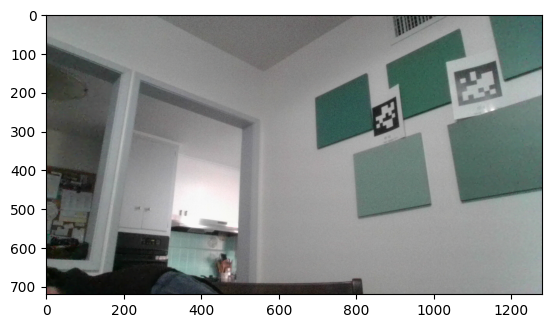

In [154]:
load_images = False
if not load_images:
    resolution = (1280, 720)
    cam = cv2.VideoCapture(0, cv2.CAP_DSHOW)  # open a regular USB cam
    cam.set(cv2.CAP_PROP_FRAME_WIDTH, resolution[0])
    cam.set(cv2.CAP_PROP_FRAME_HEIGHT, resolution[1])
    s, image_raw = cam.read()  # read from the camera
    if s > 0:  # test if the camera actually returned a success
        #s, image_raw = cam.read()  # read from the camera
        cv2.imshow(f'Image Processing Pipeline', image_raw)
    cam.release()
    # close video display on key press
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    plt.imshow(cv2.cvtColor(image_raw, cv2.COLOR_BGR2RGB))

In [155]:
# in case we need it later
test_images = Path(".") / 'test_images'  # directory for the calibration images
# cal_images.absolute()
save_images = True
if save_images:
    plt.imsave(test_images / '36h11_test_640.png', image_raw)
    # cv does not accept Paths
    cv_image = test_images / '36h11_test_cv_640.png'
    cv2.imwrite(str(cv_image), image_raw)

In [156]:
# I want to keep looking at these images
load_images = True
if load_images:
    cv_image = test_images / '16h5_test_cv_1280_z4p00m.png'
    image_raw = cv2.imread(str(cv_image))

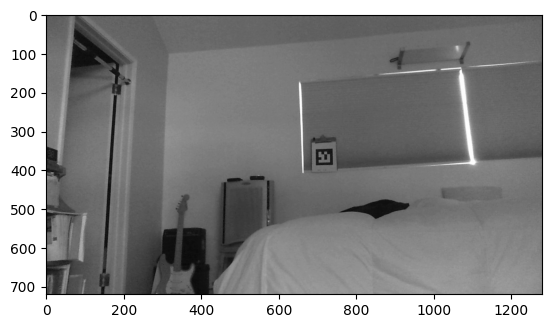

In [157]:
# this detector fails on color images
grey_image = cv2.cvtColor(image_raw, cv2.COLOR_BGR2GRAY)
plt.imshow(grey_image, cmap='gray')

#### generate some detections, call them tags

In [129]:
%%time 
detections = at_detector.detect(grey_image)
print(f'Number of detections: {len(detections)}')
tags = [det for det in detections if det.getHamming() < 2]
tag = detections[0] if len(detections) > 0 else None

Number of detections: 1
CPU times: total: 15.6 ms
Wall time: 13 ms


In [130]:
methods = ['getCenter',  'getDecisionMargin',  'getFamily',  'getHamming',
 'getHomography',  'getHomographyMatrix',  'getId']
for method in methods:
    print(f'Method: {method:20} Result: {getattr(tag, method)()}')

Method: getCenter            Result: Point(x=586.1001835699758, y=139.46373984854046)
Method: getDecisionMargin    Result: 69.28569030761719
Method: getFamily            Result: tag36h11
Method: getHamming           Result: 0
Method: getHomography        Result: (22.376584317139645, -5.428641365575909, 586.1001835699758, -9.86461434523867, 26.103463116511758, 139.46373984854046, -0.01907541197649573, -0.01584457950131074, 1.0)
Method: getHomographyMatrix  Result: [[ 2.23765843e+01 -5.42864137e+00  5.86100184e+02]
 [-9.86461435e+00  2.61034631e+01  1.39463740e+02]
 [-1.90754120e-02 -1.58445795e-02  1.00000000e+00]]
Method: getId                Result: 8


In [131]:
tag.getCorner(0)

Point(x=556.4970092773436, y=174.86685180664062)

In [132]:
# needs a tuple to return, I guess
tag.getCorners([0]*8)

(556.4970092773436,
 174.86685180664062,
 624.8685302734374,
 161.33645629882812,
 615.895263671875,
 103.83112335205077,
 549.9480590820314,
 119.06707000732422)

In [133]:
est = estimator.estimateOrthogonalIteration(tag, 50)

In [134]:
est.getAmbiguity()

0.14492390859354634

In [135]:
est.pose1

Transform3d(Translation3d(x=1.205501, y=-0.627372, z=1.741508), Rotation3d(x=-0.031045, y=0.365998, z=-0.128690))

In [136]:
est.pose2

Transform3d(Translation3d(x=1.212253, y=-0.629531, z=1.754611), Rotation3d(x=0.518939, y=0.846410, z=0.017243))

In [137]:
est.pose2.translation()

Translation3d(x=1.212253, y=-0.629531, z=1.754611)

In [138]:
%%time 
detections = at_detector.detect(grey_image)
detections2 = [det for det in detections if det.getHamming() < 2]
detections2

CPU times: total: 15.6 ms
Wall time: 10 ms


[<AprilTagDetection tag_family=tag36h11 tag_id=8 hamming=0 decision_margin=69.28569030761719 center=Point(x=586.1001835699758, y=139.46373984854046)>]

#### looks like
* positive x means the tag is on the right
* negative y means the tag is above center
* positive z is obvious, it is the distance from the center of the camera

In [139]:
# process our image with the info from detector
def pipeline(img, intrinsics=None, tag_size=0.1524):
    img_copy = img.copy()
    grey_image = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
    if intrinsics is None:
        detections = at_detector.detect(grey_image)
    else:
        detections = at_detector.detect(grey_image, estimate_tag_pose=True, camera_params=intrinsics, tag_size=tag_size)
    
    detections = [detection for detection in detections if detection.getHamming() < 2]
    for idy, detection in enumerate(detections):
    
        color = ([255*int(i) for i in f'{(idy+1) % 7:03b}'])  # trick for unique colors
        center = detection.getCenter()
        center = [int(center.x), int(center.y)]
        
        img_copy = cv2.putText(img_copy, f'{detection.getId():2d}', center, cv2.FONT_HERSHEY_SIMPLEX,1, color, 2) 
        corners = np.array(detection.getCorners([0]*8)).reshape((-1, 1, 2)).astype(dtype=np.int32)
        # corners = np.array([ [int (c) for c in corner] for corner in detection.getCorners([0]*8) ]).reshape((-1, 1, 2))
        img_copy = cv2.polylines(img_copy, [corners], isClosed=True, color=color, thickness=2)
  
    return img_copy, detections

In [140]:
# if you want to show the image with opencv as a separate window
cv2.imshow('Processed', pipeline(image_raw)[0])
cv2.waitKey(0)
cv2.destroyAllWindows()

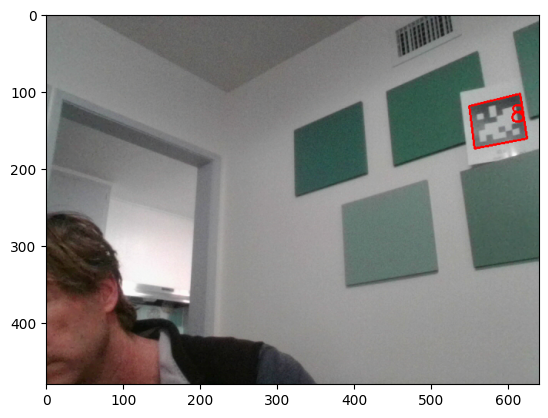

In [141]:
# show it with matplotlib instead
processed_image, tags = pipeline(image_raw)
plt.imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))

In [142]:
print('Summary of results')
for tag in tags:
    print(f'ID: {tag.getId():2}    hamming: {tag.getHamming()}   decision_margin: {tag.getDecisionMargin():2.2f}')

Summary of results
ID:  8    hamming: 0   decision_margin: 69.29


In [143]:
# with perspective, from the pose detected


#### more apriltag tricks from FRC library

In [144]:
field = ra.AprilTagField.k2024Crescendo
field_layout = ra.loadAprilTagLayoutField(field=field)

### fake a field pose estimator and update it with the vision

In [145]:
field_layout.getTagPose(8)

Pose3d(Translation3d(x=-0.038100, y=4.982718, z=1.451102), Rotation3d(x=0.000000, y=0.000000, z=0.000000))

#### tricks to get things to work

In [146]:
detections[-1]

<AprilTagDetection tag_family=tag36h11 tag_id=8 hamming=0 decision_margin=69.28569030761719 center=Point(x=586.1001835699758, y=139.46373984854046)>

In [147]:
t = [detections[-1].getCorner(i) for i in [0,1,2,3]]
t
corners = [ [int(corner.x), int(corner.y)] for corner in t ]

In [148]:
sorted(corners, key=lambda x: (x[1], x[0] ))

[[615, 103], [549, 119], [624, 161], [556, 174]]

In [149]:
# color trick
for ix in range(8):
    color = ([255*int(i) for i in f'{(ix+1) % 7:03b}'])
    print(color, )

[0, 0, 255]
[0, 255, 0]
[0, 255, 255]
[255, 0, 0]
[255, 0, 255]
[255, 255, 0]
[0, 0, 0]
[0, 0, 255]


In [150]:
# getting corners for cv polylines
buff = [0] * 8
corners = np.array(detections[-1].getCorners(buff))
# corners = np.array([ [int (c.x) for c in corner] for corner in detections[1].getCorners([]) ])
corners.reshape((-1, 1, 2))

# corners = np.array([ [int (c) for c in corner] for corner in detections[1].corners ]).reshape((-1, 1, 2))
# img_copy = cv2.polylines(img_copy, [corners], isClosed=True, color=color, thickness=2)

array([[[556.49700928, 174.86685181]],

       [[624.86853027, 161.3364563 ]],

       [[615.89526367, 103.83112335]],

       [[549.94805908, 119.06707001]]])

In [151]:
# trying a manual corner sort that doesn't always work for drawing a box with lines
t = [detections[-1].getCorner(i) for i in [0,1,2,3]]
t
corners = [ [int(corner.x), int(corner.y)] for corner in t ]
# corners = [ [int (c) for c in corner] for corner in detections[1].corners ]
corners = sorted(corners, key=lambda x: (x[1]))  # sort from top to bottom
if (corners[0][0] > corners[1][0]) and (corners[2][0] > corners[3][0]):  # swap if 1st and 3rd on same side 
    corners[2], corners[3] = corners[3], corners[2]
corners
# for idx, corner in enumerate(corners):
#     img_copy = cv2.line(img_copy, corner, corners[(idx+1)%4], color, 2)

[[615, 103], [549, 119], [556, 174], [624, 161]]